### Correlating the BL GBT/Parkes target list with Gaia DR2

This notebook finds the nearest match neighbors in the Gaia DR2 catalog to the target list for Breakthrough Listen GBT and Parkes campaign found in Isaacson 2017.  It makes use of ADQL - Astronomical Data Query Langauge, which uses much of the same syntax as SQL (you can find detailed ADQL help here: http://gea.esac.esa.int/archive-help/index.html).

This notebook perfoms queries of Gaia archive two ways - through the Gaia archive online tool and through the Python client Astroquery (from Astropy: https://github.com/astropy/astroquery/blob/master/docs/gaia/gaia.rst).  Either way gets the job done.

To access the Gaia Archive online, go to https://gea.esac.esa.int/archive/ and click "Search".  (Creating a user account is optional, but it is required if you want to upload your own custom tables, which this notebook does.  I recommend making an free account and signing in).  Click on the Advanced (ADQL) tab in the upper left.

*Note: I had trouble using the online ADQL in Chrome, but had no issues in Firefox.

![alt text](ADQL_query_3.png "Query joining my list with the hipparco gaia crossmatch list")

In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
from astroquery.gaia import Gaia
from matplotlib import pyplot as plt

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


### Read in the pipe-delimited target list from Isaacson 2017

The coordinates for each object in the Isaacson 2017 table are in h:m:s and d:m:s.  But to use the ADQL to crossmatch with Gaia DR2 archive, we need both to be in decimal degrees.  So we will read in the columns, do the math, and output a new table to use in the ADQL crossmatching.

In [2]:
# Read in Issacson 2017 target table:
f = pd.read_table("asu.tsv",header=[47,48,49],sep="|")

#Extract values from table into arrays for doing math:
Star = f['Star'].values[:,0]
# Remove white space from end of strings in Star:
for i in np.arange(len(Star)):
    Star[i] = Star[i].strip()
    
RA = f['RAJ2000'].values[:,0]
Dec = f['DEJ2000'].values[:,0]

# Convert RA from hour angle to degrees:
c = SkyCoord(ra=RA, dec=Dec, unit=(u.hourangle, u.deg))
RA=c.ra.degree

# Convert Dec from DMS to decimal degrees:
c = SkyCoord(ra=RA, dec=Dec, unit=(u.hourangle, u.deg))
Dec=c.dec.degree

Ep = f['Ep'].values[:,0]
Vmag = f['Vmag'].values[:,0]
SpType = f['SpType'].values[:,0]
Dist = f['Dist'].values[:,0] # In pc
pmRA = f['pmRA'].values[:,0] # In arcsec/yr
pmDE = f['pmDE'].values[:,0] # In arcsec/yr
SimbadName = f['SimbadName'].values[:,0]


### Construct a table of the new values and write out as a new VOtable:

In [3]:
from astropy.table import Table
t = Table([Star, RA, Dec, Ep, Vmag, SpType, Dist, pmRA, pmDE, SimbadName], names=('Star', 'RA', 'Dec', 'Ep', \
                                                                                 'Vmag', 'SpType', 'Dist', 'pmRA',\
                                                                                  'pmDE', 'SimbadName'))
#print t
t.write('Isaacson2017.xml', format='votable',overwrite=True)
t.write('Isaacson2017.csv', format='csv',overwrite=True)

Let's read it back in to be sure its a valid VOtable

In [4]:
from astropy.io.votable import parse
votable = parse("Isaacson2017.xml")
table = votable.get_first_table()
#table

Now we can use this file to crossmatch with Gaia DR2 archive.

### Crossmatching the table with the Gaia DR2 archive using the ADQL python client

### Cone Search:

This script launches a query of the Gaia DR database.  It takes in the RA and Dec positions of the Isaacson 2017 table and searches for matching Gaia sources that fall within 5" (0.00138 deg) of those positions, and outputs the sources to a file.  The file is gzipped, so before it can be read in you must find the file, unzip it, and get the name the archive assigned it.

The default output format is 'VOtable', but I have found VOtables increadibly difficult to work with.  So I chose to ask it to give me the results as a csv, which has been much simpler for me.

In [8]:
upload_resource = "Isaacson2017.xml"
j = Gaia.launch_job(query="SELECT * , distance(POINT('ICRS', h.ra, h.dec),\
                    POINT('ICRS', gaia.ra, gaia.dec)) FROM gaiadr2.gaia_source AS gaia, \
                    tap_upload.my_table AS h WHERE 1=CONTAINS(POINT('ICRS', h.ra, h.dec),\
                    CIRCLE('ICRS', gaia.ra, gaia.dec, 0.00138))", upload_resource=upload_resource, \
                    upload_table_name="my_table", verbose=False, dump_to_file=True, output_format='csv')
#r = j.get_results()
#r.pprint()



Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


Read in the search results:

In [4]:
d = pd.read_csv('sync_20180611094152.csv')

In [5]:
d.shape

(1110, 107)

The problem with this method is that it finds all Gaia DR2 sources within 5 arcsec of the RA/Dec of the Isaacson 2017 targets.  There might be (there are) more or less than 1 Gaia source within that 5 arcsec cone.  Directly crossmatching the Gaia sources in this way is difficult and problematic.

### Crossmatching with built-in tables:

Fortunately, the GAIA archive already has done some cross-matching of their sources with nearest neighbors of common other catalogs.  Let's start with that to find the DR2 source id matching our stars in the Isaacson 2017 target list.

Let's start with Hipparcos catalog stars, since that's the majority of our targets and one of Gaia's already crossmatched catalogs.  First find the HIP stars in our list, and remove the "HIP" prefix (because the crossmatch catalog only uses the numbers as source ids)

This cell loads the Gaia/Hipparcos "Best Neighbour" crossmatching table:

In [7]:
hip_xmatch_table = Gaia.load_table('gaiadr2.hipparcos2_best_neighbour')
for column in (hip_xmatch_table.get_columns()):
    print(column.get_name())

Retrieving table 'gaiadr2.hipparcos2_best_neighbour'
Parsing table 'gaiadr2.hipparcos2_best_neighbour'...
Done.
source_id
original_ext_source_id
angular_distance
number_of_neighbours
gaia_astrometric_params


So, we see that the crossmatch table only carries a few pieces of information about each source, not the full Gaia astrometric solution.

This cell retrieves every object in the best neighbor table and dumps it into a csv file:

In [137]:
j = Gaia.launch_job(query="SELECT * FROM gaiadr2.hipparcos2_best_neighbour",\
                    verbose=False, dump_to_file=True, output_format='csv')

In [6]:
d = pd.read_csv('sync_20180612094811.csv')
d.shape
#print d

(2000, 5)

In [7]:
orig_ext_source_id = d['original_ext_source_id'].values
gaia_id = d['source_id'].values
print orig_ext_source_id

[46812 47336 25554 ..., 18718 20952 30820]


Now we need to get the Isaacson target list into a format where it can be easily joined with the best neighbor table.

In [8]:
I_hip_numbers = np.array([])
indicies1 = np.array([])
newstar=np.array([])
I_hip_id = np.array([])

# Make a list of all the "HIP" stars in the target list
for item in Star:
    if item.find("HIP") == 0:
        newstar = np.append(newstar,item)
print newstar.shape

# For each of those stars, find the corresponding row in the target list and compile
# a list of those indicies:
index = np.arange(0,newstar.shape[0],1)
for i in index:
    ind = np.where(Star==newstar[i])[0][0]
    indicies1 = np.append(indicies1,ind)
indicies1 = np.asarray(indicies1, dtype=np.int, order='C')

# For each of those stars, remove the "HIP" prefix:
for item in Star[indicies1]:
    I_hip_id = np.append(I_hip_id,item)
    i = item.strip("HIP")
    I_hip_numbers = np.append(I_hip_numbers,i)

# Convert the string to float:
I_hip_numbers = np.asarray(I_hip_numbers, dtype=np.float64, order='C')

print RA[indicies1].shape
print I_hip_numbers.shape

I_ra,I_dec,I_pmRA,I_pmDE,I_id = RA[indicies1],Dec[indicies1],pmRA[indicies1], pmDE[indicies1],SimbadName[indicies1]

(1649,)
(1649,)
(1649,)


Write out a new table of the selected stars:

In [9]:
from astropy.table import Table
t = Table([I_hip_numbers, RA[indicies1], Dec[indicies1], Ep[indicies1], Vmag[indicies1], SpType[indicies1],\
           Dist[indicies1], pmRA[indicies1], pmDE[indicies1], SimbadName[indicies1]], names=('original_ext_source_id',\
                                                                                         'RA', 'Dec', 'Ep', 'Vmag',\
                                                                                         'SpType', 'Dist', 'pmRA',\
                                                                                         'pmDE', 'SimbadName'))
#print t
t.write('Isaacson2017_hip.xml', format='votable',overwrite=True)

In [12]:
# When I attempted to perform this search with the Python client it failed, so I used the online tool instead.

#upload_resource = "Isaacson2017_hip.xml"
#j = Gaia.launch_job(query='SELECT * FROM gaiadr2.hipparcos2_best_neighbour AS h1 JOIN user_lpearce.table2 AS t1 \
#                    USING (original_ext_source_id)', upload_resource=upload_resource, \
#                    upload_table_name="user_lpearce.table2", verbose=True, dump_to_file=True, output_format='csv')

This time I used the Gaia archive online ADQL tool to submit the query.  First signed in and uploaded the table I made in previous cell to user tables.  Then I performed the query joining my list with the Gaia Hip crossmatch list:
![alt text](ADQL_query_1.png "Query joining my list with the hipparco gaia crossmatch list")

### The results:

In [10]:
d = pd.read_csv('1528826570739O-result.csv')
gaia_hip_name = d['simbadname']
gaia_hip_id = d['source_id']
print d.shape
#print d
hip_simbadname = SimbadName[indicies1]

(1084, 15)


Let's check that the Gaia list matches our list:

In [11]:
index = np.arange(0,d.shape[0],1)
indicies=np.array([])
for i in index:
    ind = np.where(Star==gaia_hip_name[i])[0][0]
    indicies = np.append(indicies,ind)
indicies = np.asarray(indicies, dtype=np.int, order='C')
print indicies.shape

# From the target list pull out just the Hipparcos sources in the crossmatch catalog:
hip_name, hip_ra, hip_dec = Star[indicies], RA[indicies], Dec[indicies]
hip_pmRA,hip_pmDE,hip_Vmag = pmRA[indicies], pmDE[indicies],Vmag[indicies]

#for i in index:
#    print gaia_hip_name[i],hip_name[i]

(1084,)


But the crossmatch catalog only gives a limited amount of information from the Gaia source catalog. (Close inspection shows that the RA/Dec given in this result is the same RA/Dec we fed in from our table above.  The join operation merged the two orginal catalog names columns and kept the rest from each distinct table.)

To get the full Gaia solution, we need to do another join search using the Gaia source id

In [12]:
# Make another table of just the source ids:
t = Table([gaia_hip_id, gaia_hip_name], names=('source_id', 'original_ext_source_id'))
t.write('Isaacson2017_hip_gaia_sourceid.xml', format='votable',overwrite=True)

This time I performed a join search of the gaia source id's in this list with the full Gaia DR2 catalog to get the full astrometric solution from the catalog:
![alt text](ADQL_query_2.png "Query joining my list with the gaia archive")

In [13]:
d = pd.read_csv('1528844930818O-result.csv')


Let's see what the columns are the we got in this result.  We got back all the same columns from the uploaded table (just source_id and hipparcos name), plus all the Gaia DR2 columns.  This cell reports what those columns are:

In [14]:
table = Gaia.load_table('gaiadr2.gaia_source')
for column in (table.get_columns()):
    print(column.get_name())

Retrieving table 'gaiadr2.gaia_source'
Parsing table 'gaiadr2.gaia_source'...
Done.
solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
astrometric_weight_al
astrometric_pseudo_colour
astrometric_pseudo_colour_error
mean_varpi_factor_al
astrometric_matched_observations
visibility_periods_used
astrometric_sigma5d_max
frame_rotator_object_type
matched_observations
duplicated_source
phot_g_n_obs
phot_g_mean_flux
phot_g_mean_flux_error
phot_g_mean_flux_over_error
phot_g_mean_mag
phot_bp_n_obs
ph

In [17]:
d

,solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,...,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,table3_oid,original_ext_source_id,source_id
0,1635721458409799680,Gaia DR2 4456127942261895808,249952572,2015.5,238.033158,0.176074,10.873433,0.129932,47.286021,0.174709,...,0.770258,0.886812,0.173393,0.172652,0.174134,http://geadata.esac.esa.int/data-server/datali...,NaN,1,HIP77725,4456127942261895808
1,1635721458409799680,Gaia DR2 3736865265439463424,941933325,2015.5,195.542953,0.351067,10.959234,0.339533,30.562390,0.437867,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,2,HIP63608,3736865265439463424
2,1635721458409799680,Gaia DR2 3294081521934473216,620716494,2015.5,71.108053,0.155121,11.146074,0.093180,22.005976,0.170694,...,1.984855,2.073136,11.532942,11.428845,11.637038,http://geadata.esac.esa.int/data-server/datali...,NaN,3,HIP22044,3294081521934473216
3,1635721458409799680,Gaia DR2 3883317121883053184,1090725393,2015.5,155.539625,0.085986,11.308845,0.089442,36.845923,0.103151,...,0.828031,0.872127,0.532284,0.530489,0.534080,http://geadata.esac.esa.int/data-server/datali...,NaN,4,HIP50782,3883317121883053184
4,1635721458409799680,Gaia DR2 3339921875389105152,63198751,2015.5,84.129115,0.045984,11.327626,0.042810,87.436741,0.056184,...,0.534643,0.581374,0.079318,0.079207,0.079429,http://geadata.esac.esa.int/data-server/datali...,NaN,5,HIP26335,3339921875389105152
5,1635721458409799680,Gaia DR2 602079652404802688,633441613,2015.5,129.961153,0.042567,11.520517,0.030083,54.159317,0.050783,...,0.714413,0.791423,0.320196,0.319784,0.320609,http://geadata.esac.esa.int/data-server/datali...,NaN,6,HIP42499,602079652404802688
6,1635721458409799680,Gaia DR2 4312905248400130688,1012686690,2015.5,288.896861,0.035018,11.553972,0.031556,37.953990,0.045588,...,0.834510,0.862376,0.427354,0.426619,0.428090,http://geadata.esac.esa.int/data-server/datali...,NaN,7,HIP94650,4312905248400130688
7,1635721458409799680,Gaia DR2 25488745411919360,1253173220,2015.5,41.573147,0.043952,11.774328,0.036097,61.912845,0.046121,...,0.704094,0.757716,0.159351,0.159154,0.159548,http://geadata.esac.esa.int/data-server/datali...,NaN,8,HIP12929,25488745411919360
8,1635721458409799680,Gaia DR2 36590651757883392,1174617184,2015.5,56.214405,0.057323,11.920553,0.033729,45.606108,0.061102,...,0.666587,0.727233,0.165433,0.165139,0.165728,http://geadata.esac.esa.int/data-server/datali...,NaN,9,HIP17496,36590651757883392
9,1635721458409799680,Gaia DR2 3331979901042416512,1311244815,2015.5,94.111278,0.167063,12.272966,0.163166,51.192953,0.190722,...,1.352465,1.426135,3.086416,3.071476,3.101355,http://geadata.esac.esa.int/data-server/datali...,NaN,10,HIP29800,3331979901042416512


Now we can compare the Gaia info to the Isaacson 2017 info for each source in the Hipparcos catalog:

In [15]:
# Pull out some of the Gaia columns:
source_id = d['source_id'].values
gaia_id = d['designation'].values
gaia_ra = d['ra'].values
gaia_dec = d['dec'].values
gaia_pmRA,gaia_pmDE = d['pmra'].values,d['pmdec'].values
gaia_Gmag = d['phot_g_mean_mag'].values
gaia_parallax = d['parallax'].values
print source_id.shape


(1084,)


So not all of our Hipparcos targets are in the Gaia/Hip crossmatch catalog.  Let me just take the ones that are:

In [19]:
t = Table([hip_name, gaia_id, hip_ra, gaia_ra, hip_dec, gaia_dec, hip_pmRA, gaia_pmRA,hip_pmDE,gaia_pmDE,\
          hip_Vmag,gaia_Gmag,gaia_parallax], names=('Hip ID','Gaia Source ID','Hip RA','Gaia RA','Hip Dec','Gaia Dec',\
                                                   'Hip pmRA','Gaia pmRA','Hip pmDE','Gaia pmDE','Hip Vmag',\
                                                   'Gaia Gmag','Gaia Parallax'))

t.write('I17_hip_gaia_xmatch_results.csv', format='csv',overwrite=True)
t

Hip ID,Gaia Source ID,Hip RA,Gaia RA,Hip Dec,Gaia Dec,Hip pmRA,Gaia pmRA,Hip pmDE,Gaia pmDE,Hip Vmag,Gaia Gmag,Gaia Parallax
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HIP77725,Gaia DR2 4456127942261895808,238.034166667,238.033158331,10.8744444444,10.8734326948,-0.27,-266.050295056,-0.24,-240.818742659,9.34,8.708041,47.2860213582
HIP63608,Gaia DR2 3736865265439463424,195.544166667,195.542953267,10.9588888889,10.9592337248,-0.28,-270.241216884,0.02,21.7534740432,2.85,2.4549925,30.5623898847
HIP22044,Gaia DR2 3294081521934473216,71.1075,71.1080526107,11.1461111111,11.1460741791,0.1,98.8149230578,-0.01,-14.8805409101,5.39,5.3106313,22.0059763819
HIP50782,Gaia DR2 3883317121883053184,155.539583333,155.53962467,11.31,11.3088449245,0.02,21.4664738992,-0.32,-324.425471602,7.78,7.568791,36.8459232812
HIP26335,Gaia DR2 3339921875389105152,84.1291666667,84.1291147087,11.3277777778,11.3276260973,0.0,-2.75207416658,-0.06,-56.6483154475,8.78,8.2080145,87.4367409734
HIP42499,Gaia DR2 602079652404802688,129.961666667,129.961152566,11.5225,11.520517174,-0.11,-109.250286155,-0.5,-500.554775473,7.61,7.3464313,54.1593169089
HIP94650,Gaia DR2 4312905248400130688,288.895833333,288.896861475,11.5544444444,11.5539722895,0.18,183.441776206,-0.17,-172.918256974,8.06,7.79394,37.9539903441
HIP12929,Gaia DR2 25488745411919360,41.5720833333,41.5731471602,11.775,11.7743281445,0.27,263.849184194,-0.21,-211.596388823,8.59,8.106816,61.9128454299
HIP17496,Gaia DR2 36590651757883392,56.2129166667,56.2144049331,11.92,11.9205531196,0.32,314.300028213,0.13,127.598054363,9.13,8.651253,45.6061082575


But many of the Hipparcos sources were missing from the Xmatch catalog:

In [20]:
print 'Number of missing Hip sources:',I_hip_numbers.shape[0]-source_id.shape[0]

# Find the index for all the Hipparcos objects not in the Gaia xmatch catalog:
missingItems = [x for x in indicies1 if not x in indicies]
missing_hip_id = Star[missingItems]

# Check that all of these are in fact missing from our previous table:
#for i in range(missing_hip_id.shape[0]):
#    print np.where(hip_name==missing_hip_id[i])

Number of missing Hip sources: 565


## Update the RA/Dec:
I2017 uses ref epoch 2000, while Gaia uses 2015.5.  We can increase the likelihood of a match by updating the RA/Dec of I2017 to 2015.5 to have a better shot at being close to the Gaia sources.

In [16]:
# Convert the target list proper motions to degrees/yr
pmRA_deg,pmDE_deg = (pmRA*u.arcsec).to(u.deg).value,(pmDE*u.arcsec).to(u.deg).value
# Compute the difference between the ref epoch and updated epoch:
deltat = 2015.5-1991.25
# Add the delta RA/Dec to the target list RA/Dec:
RA_J20155 = RA+(pmRA_deg*deltat)
Dec_J20155 = Dec+(pmDE_deg*deltat)
print RA_J20155

Ep_20155 =  np.repeat('2015.5',1709)

[  5.37916667e-03   5.37664583e-01   5.47754167e-01 ...,   3.59805534e+02
   3.59871769e+02   3.59948762e+02]


In [17]:
# Compare:
print 'HIP169 RA in Gaia (ref 2015.5), I2017 (ref nominally 2000), and I2017 ref 2000 adjusted to 2015.5 '
print gaia_ra[np.where(hip_name==SimbadName[1])[0]],RA[1],RA_J20155[1]
print gaia_dec[np.where(hip_name==SimbadName[1])[0]],Dec[1],Dec_J20155[1]

HIP169 RA in Gaia (ref 2015.5), I2017 (ref nominally 2000), and I2017 ref 2000 adjusted to 2015.5 
[ 0.53888552] 0.53625 0.537664583333
[-68.28173987] -68.2805555556 -68.2821048611


In [18]:
# Make a new target list table with the updated RA/Dec values for all 1709 sources:
t = Table([Star, RA_J20155, Dec_J20155, Ep_20155, Vmag, SpType, Dist, pmRA, pmDE, SimbadName], names=('Star', \
                                                                                                      'RAJ20155',\
                                                                                                      'Dec20155', 'Ep', \
                                                                                                      'Vmag', 'SpType',\
                                                                                                      'Dist', 'pmRA',\
                                                                                                      'pmDE', 'SimbadName'))
#print t
t.write('Isaacson2017_ref20155.xml', format='votable',overwrite=True)
t.write('Isaacson2017_ref20155.csv', format='csv',overwrite=True)

# Taking a different tack.

The Gaia archive crossmatch tables don't have very many of our sources.  So I researched how other programs do the crossmatching work.

### Gaia Kepler Fun
Author Meg Bedell has a description of how she did the crossmatching here: https://github.com/megbedell/gaia-kepler.fun/blob/master/scripts/HOWTO.md
She used a cone search around the Kepler RA/Dec just as I did before.  The difference is that she included this line in her query: distance(
  POINT('ICRS', kepler.ra_kic, kepler.dec_kic),
  POINT('ICRS', gaia.ra, gaia.dec)) AS angDist
This puts an "angular distance" column into the result.  This allows me to compare, in cases where two Gaia sources where found for a target list id, the angular distances of the two Gaia results.

This is also how the Gaia Basic search works.  You put in a source name like "HIP4288", and the basic search form looks up the RA/Dec from Simbad and performs a search within a radius (the default is 5", which is the same search radius I use here).

I uploaded the above table and performed the following query on the Gaia ADQL:  
SELECT * , distance(
  POINT('ICRS', t.raj20155, t.dec20155),
  POINT('ICRS', gaia.ra, gaia.dec)) AS angDist
FROM gaiadr2.gaia_source AS gaia, user_lpearce.table4 AS t
WHERE 1=CONTAINS(
  POINT('ICRS', t.raj20155, t.dec20155),
  CIRCLE('ICRS', gaia.ra, gaia.dec, 0.001388889)
)

In [19]:
d = pd.read_csv('1528929673010O-result.csv')
print d.shape

(1748, 108)


So this produced several duplicates where it found more than one Gaia source for some 

In [20]:
d

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,raj20155,dec20155,ep,vmag,sptype,dist,pmra.1,pmde,simbadname,angdist
0,1635721458409799680,Gaia DR2 2341871673090078592,2341871673090078592,1481689922,2015.5,0.005093,0.267211,-19.498840,0.178723,25.120767,...,0.004942,-19.498611,2015.5,9.27,K3V,45.60,0.18,0.00,HIP2,0.000270
1,1635721458409799680,Gaia DR2 4706564427272810624,4706564427272810624,592068553,2015.5,0.538886,0.454880,-68.281740,0.452342,65.808293,...,0.537154,-68.281546,2015.5,9.24,M0V,15.80,0.21,-0.23,HIP169,0.000669
2,1635721458409799680,Gaia DR2 2853900872207150720,2853900872207150720,324321780,2015.5,0.546585,0.770322,27.077779,0.709696,79.069609,...,0.545858,27.078261,2015.5,5.80,G3V,12.40,0.78,-0.92,HIP171,0.000807
3,1635721458409799680,Gaia DR2 2746883550048724992,2746883550048724992,873465422,2015.5,0.623350,0.343970,8.485262,0.149161,26.785189,...,0.623362,8.485062,2015.5,5.70,F0V,37.60,-0.09,-0.05,HIP194,0.000199
4,1635721458409799680,Gaia DR2 2848150288954631296,2848150288954631296,716361197,2015.5,1.236466,0.047620,23.269597,0.042992,37.924647,...,1.236219,23.269401,2015.5,7.82,G9V,25.60,0.38,-0.01,HIP400,0.000300
5,1635721458409799680,Gaia DR2 386655019234960128,386655019234960128,277664169,2015.5,1.299010,0.157228,45.785055,0.069012,0.128785,...,1.299162,45.785743,2015.5,9.95,M2,11.40,0.87,-0.15,HIP428,0.000696
6,1635721458409799680,Gaia DR2 386655019234959872,386655019234959872,665449823,2015.5,1.300748,0.037335,45.785915,0.023836,86.956702,...,1.299162,45.785743,2015.5,9.95,M2,11.40,0.87,-0.15,HIP428,0.001119
7,1635721458409799680,Gaia DR2 4706630501049679744,4706630501049679744,1534910858,2015.5,1.322372,0.028273,-67.835003,0.023457,61.031283,...,1.323233,-67.834911,2015.5,8.49,K5V,16.00,-0.12,-0.56,HIP436,0.000338
8,1635721458409799680,Gaia DR2 2444348733778920832,2444348733778920832,664581359,2015.5,1.333869,0.440821,-5.707235,0.226905,NaN,...,1.333707,-5.707113,2015.5,4.61,K1III,39.40,-0.01,0.09,HIP443,0.000203
9,1635721458409799680,Gaia DR2 423075173680043904,423075173680043904,1632509498,2015.5,1.567845,0.034364,58.436857,0.030864,47.800547,...,1.566910,58.436753,2015.5,5.98,G5V,20.20,0.25,0.02,HIP518,0.000501


### Using np.loadtxt instead...

I found that deleting a row from a pandas dataframe was unnecessarily complicated, did not work the way I thought it did, and produced many errors making it impossible to work with easily.  So I switched to np.loadtxt to load the csv tables, which produces a matrix of (as I made it) strings, and allows easy manipulation of rows in a way that makes sense to me.  I still output the results as a csv table, so we lose nothing by abandoning the pandas dataframe.

In [21]:
f = np.loadtxt(open('1528929673010O-result.csv',"rb"),
                delimiter=",",dtype=str)
print f.shape
print f[0,:]

(1749, 108)
['solution_id' 'designation' 'source_id' 'random_index' 'ref_epoch' 'ra'
 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'ra_dec_corr' 'ra_parallax_corr' 'ra_pmra_corr' 'ra_pmdec_corr'
 'dec_parallax_corr' 'dec_pmra_corr' 'dec_pmdec_corr' 'parallax_pmra_corr'
 'parallax_pmdec_corr' 'pmra_pmdec_corr' 'astrometric_n_obs_al'
 'astrometric_n_obs_ac' 'astrometric_n_good_obs_al'
 'astrometric_n_bad_obs_al' 'astrometric_gof_al' 'astrometric_chi2_al'
 'astrometric_excess_noise' 'astrometric_excess_noise_sig'
 'astrometric_params_solved' 'astrometric_primary_flag'
 'astrometric_weight_al' 'astrometric_pseudo_colour'
 'astrometric_pseudo_colour_error' 'mean_varpi_factor_al'
 'astrometric_matched_observations' 'visibility_periods_used'
 'astrometric_sigma5d_max' 'frame_rotator_object_type'
 'matched_observations' 'duplicated_source' 'phot_g_n_obs'
 'phot_g_mean_flux' 'phot_g_mean_flux_error' 'phot_g_mean_flux_

'SimbadName' array is the list of Simbad names for the I2017 target list.  'hip_id' is the Hipparcos (and other) catalog names in the gaia search results.  

'h' prefix means I2017, 'g' prefix refers to Gaia search result

In [22]:
gaia_id = f[:,2]
hip_id = f[:,106]
hpmra,hpmde = f[:,104],f[:,105]
gpmra,gpmde = f[:,12],f[:,14]
hvmag,ggmag = f[:,101],f[:,50]
hdist,gparallax = f[:,103],f[:,9]
angdist = f[:,107]

Count the number of duplicates:

In [23]:
one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

Triples and quads: (8,)
Doubles: (158,)
Singles: (1417,)
No Gaia ids: (126,)


### Attempting to identify the correct corresponding Gaia source for each item in I2017 list

By comparing the properties of the duplicated sources to the properties in I2017, it is sometimes clear which is the corresponding source.  This script compares the proper motions, magnitudes, dist/parallax, and angdist for each repeat.  Things I'm looking for: <br>
Proper motions: Should approximately match.  Keep in mind that I2017 lists pm in arcsec/yr and Gaia in mas/yr<br>
Magnitudes: I2017 gives V mag, and Gaia gives g mag.  So they won't match perfectly but they should be close.  (This is often the best distinguisher I've found)<br>
Dist/Parallax: These should not match at all, since they're very different, but you can look for broad trends.  If the source has a small distance it should have a large parallax value, so this can be used to make broad distinctions (this doesn't often help if there aren't other indicators of which one is correct)<br>
Angdist: This is the angular distance from the reference (I2017) coordinates.  Given that there is a lot of room for variation in the coordinates, this really shouldn't be used to distinguish (i.e. don't assume that the closer source is necessarily the correct one)

Triples and quads first:

In [24]:
print other_gaiasource
for item in other_gaiasource:
    print np.where(hip_id==item)
    ii = np.where(hip_id==item)[0]
    print hip_id[ii]
    print gaia_id[ii]
    print hpmra[ii],gpmra[ii]
    print hpmde[ii],gpmde[ii]
    print hvmag[ii],ggmag[ii]
    print hdist[ii],gparallax[ii]
    print angdist[ii]
    print ''

['HIP20648' 'HIP24783' 'HIP76074' 'HIP79958' 'HIP83846' 'HIP90959'
 'HIP97222' 'HIP97222']
(array([308, 309, 310]),)
['HIP20648' 'HIP20648' 'HIP20648']
['3314063977537054336' '3314063977537054464' '3314063977537054208']
['0.11' '0.11' '0.11'] ['' '' '109.64518000672828']
['-0.03' '-0.03' '-0.03'] ['' '' '-30.806134750908342']
['4.3' '4.3' '4.3'] ['8.10834' '7.9293137' '4.262473']
['45.3' '45.3' '45.3'] ['' '' '22.194704125402314']
['3.644286916421309E-4' '6.359712481390226E-4' '1.3395485430671815E-4']

(array([381, 382, 383]),)
['HIP24783' 'HIP24783' 'HIP24783']
['2962193318618003584' '2962193318614307200' '2962193318618221056']
['-0.14' '-0.14' '-0.14'] ['-138.47103373978067' '4.256794931463376' '-137.05467276899483']
['-0.04' '-0.04' '-0.04'] ['-43.89935986348208' '-0.8629304872421891' '-36.939759047355395']
['9.35' '9.35' '9.35'] ['11.259693' '17.136875' '8.85017']
['20.2' '20.2' '20.2'] ['49.469924520798905' '3.8308777269446677' '48.9480317777374']
['0.0012842271806702628' '0.00116

Drop the identified multiples and reassign variables for the new data array, and write out the new array to a file to save progress:

*Note: only run this cell once, rerunning it will remove the wrong sources.

In [25]:
drop = [308,309,1434,1435,1436,1343,1344,1230,1231,1158,1159,1093,1094,1096,381,382]

f = np.delete(f, drop, axis=0)

import csv
b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()
print f.shape

gaia_id = f[:,2]
hip_id = f[:,106]
hpmra,hpmde = f[:,104],f[:,105]
gpmra,gpmde = f[:,12],f[:,14]
hvmag,ggmag = f[:,101],f[:,50]
hdist,gparallax = f[:,103],f[:,9]
angdist = f[:,107]

one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

(1733, 108)
Triples and quads: (0,)
Doubles: (158,)
Singles: (1425,)
No Gaia ids: (126,)


Now doubles.  There are so many let's do it in batches<br>
(I'm going to run this cell in groups of 10 up to 50 total doubles in this batch)

In [26]:
print two_gaiasource.shape
for item in two_gaiasource[41:50]:
    print np.where(hip_id==item)
    ii = np.where(hip_id==item)[0]
    print hip_id[ii]
    print gaia_id[ii]
    print 'pmra',hpmra[ii],gpmra[ii]
    print 'pmde',hpmde[ii],gpmde[ii]
    print 'mag',hvmag[ii],ggmag[ii]
    print 'dist,par',hdist[ii],gparallax[ii]
    print 'angdist',angdist[ii]
    print ''

(158,)
(array([618, 619]),)
['HIP43557' 'HIP43557']
['596878550087942400' '596878550087942528']
pmra ['0.15' '0.15'] ['189.3985144862685' '151.38642122189378']
pmde ['-0.24' '-0.24'] ['-241.91289126258798' '-234.79718204379353']
mag ['6.57' '6.57'] ['12.005346' '6.4061203']
dist,par ['24.1' '24.1'] ['44.383085603072274' '43.44889459144193']
angdist ['0.0010577408348160136' '1.646234778467985E-4']

(array([633, 634]),)
['HIP44295' 'HIP44295']
['610304716643271808' '610304720934423424']
pmra ['-0.13' '-0.13'] ['-110.93365368558733' '-126.03278166727966']
pmde ['-0.32' '-0.32'] ['-314.541827244994' '-321.38143234545055']
mag ['8.67' '8.67'] ['8.911361' '8.734799']
dist,par ['18.3' '18.3'] ['54.27621810648814' '54.130982562354106']
angdist ['0.001197088147958699' '2.254791212696314E-4']

(array([640, 641]),)
['HIP44955' 'HIP44955']
['712329087779343744' '712329057712195584']
pmra ['-0.33' '-0.33'] ['-328.7371479613545' '']
pmde ['-0.63' '-0.63'] ['-635.7459678839774' '']
mag ['9.96' '9.96'

In [27]:
drop = [6,11,82,105,115,123,131,142,154,179,201,218,233,250,259,266,283,333,347,367,380,384,385,\
        407,425,446,464,471,514,564,606,607,610,618,633,641,644,651,653,655,674]

f = np.delete(f, drop, axis=0)

import csv
b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()
print f.shape

gaia_id = f[:,2]
hip_id = f[:,106]
hpmra,hpmde = f[:,104],f[:,105]
gpmra,gpmde = f[:,12],f[:,14]
hvmag,ggmag = f[:,101],f[:,50]
hdist,gparallax = f[:,103],f[:,9]
angdist = f[:,107]

one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

(1692, 108)
Triples and quads: (0,)
Doubles: (117,)
Singles: (1466,)
No Gaia ids: (126,)


Next batch:

In [28]:
print two_gaiasource.shape
for item in two_gaiasource[41:50]:
    print np.where(hip_id==item)
    ii = np.where(hip_id==item)[0]
    print hip_id[ii]
    print gaia_id[ii]
    print 'pmra',hpmra[ii],gpmra[ii]
    print 'pmde',hpmde[ii],gpmde[ii]
    print 'mag',hvmag[ii],ggmag[ii]
    print 'dist,par',hdist[ii],gparallax[ii]
    print 'angdist',angdist[ii]
    print ''

(117,)
(array([941, 942]),)
['HIP67960' 'HIP67960']
['6176833918555679488' '6176833914259261568']
pmra ['-0.28' '-0.28'] ['' '-257.56314320282826']
pmde ['-0.1' '-0.1'] ['' '-93.31190656908643']
mag ['9.53' '9.53'] ['11.302307' '8.878919']
dist,par ['16.7' '16.7'] ['' '59.510879197189176']
angdist ['3.325391182686758E-4' '3.175263085853126E-4']

(array([953, 954]),)
['HIP69454' 'HIP69454']
['5895265380327966464' '5895265380327966464']
pmra ['0.36' '0.36'] ['353.9243005571954' '353.9243005571954']
pmde ['0.18' '0.18'] ['179.3492258022569' '179.3492258022569']
mag ['10.2' '10.2'] ['9.3408575' '9.3408575']
dist,par ['11.7' '11.7'] ['85.75171946603162' '85.75171946603162']
angdist ['6.237273487241969E-4' '6.237273487241969E-4']

(array([953, 954]),)
['HIP69454' 'HIP69454']
['5895265380327966464' '5895265380327966464']
pmra ['0.36' '0.36'] ['353.9243005571954' '353.9243005571954']
pmde ['0.18' '0.18'] ['179.3492258022569' '179.3492258022569']
mag ['10.2' '10.2'] ['9.3408575' '9.3408575']
di

In [29]:
drop = [137,253,412,546,658,685,695,712,730,733,747,753,761,782,799,816,821,835,839,841,844,846,864,867,876,\
       884,896,929,941,953,958,966,1002,1011,1018]

f = np.delete(f, drop, axis=0)

import csv
b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()
print f.shape

gaia_id = f[:,2]
hip_id = f[:,106]
hpmra,hpmde = f[:,104],f[:,105]
gpmra,gpmde = f[:,12],f[:,14]
hvmag,ggmag = f[:,101],f[:,50]
hdist,gparallax = f[:,103],f[:,9]
angdist = f[:,107]

one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

(1657, 108)
Triples and quads: (0,)
Doubles: (80,)
Singles: (1503,)
No Gaia ids: (126,)


In [35]:
print two_gaiasource.shape
for item in two_gaiasource[41:50]:
    print np.where(hip_id==item)
    ii = np.where(hip_id==item)[0]
    print hip_id[ii]
    print gaia_id[ii]
    print 'pmra',hpmra[ii],gpmra[ii]
    print 'pmde',hpmde[ii],gpmde[ii]
    print 'mag',hvmag[ii],ggmag[ii]
    print 'dist,par',hdist[ii],gparallax[ii]
    print 'angdist',angdist[ii]
    print ''

(80,)
(array([1246, 1247]),)
['HIP90139' 'HIP90139']
['4529285391531266304' '4529285391522200320']
pmra ['0.2' '0.2'] ['' '196.02727134872694']
pmde ['-0.24' '-0.24'] ['' '-241.7092162709215']
mag ['3.85' '3.85'] ['3.395253' '3.3893392']
dist,par ['39.3' '39.3'] ['' '27.457853411040162']
angdist ['1.8389063544963115E-4' '1.6928088055377044E-5']

(array([1262, 1263]),)
['HIP91430' 'HIP91430']
['4103671239732631936' '4103671239353204864']
pmra ['0.11' '0.11'] ['112.37605740976814' '-3.1999037182208143']
pmde ['-0.57' '-0.57'] ['-568.8189377287136' '-4.137525302271747']
mag ['11.2' '11.2'] ['10.235449' '14.752581']
dist,par ['12.7' '12.7'] ['74.71421188423355' '0.11280312793945246']
angdist ['3.483081782706382E-4' '0.0012079793040531113']

(array([1268, 1269]),)
['HIP91919' 'HIP91919']
['2098237660363229312' '2098237656065233792']
pmra ['0.01' '0.01'] ['9.296725976986908' '1.8276094060693833']
pmde ['0.06' '0.06'] ['75.29147111635339' '49.54924577426016']
mag ['4.67' '4.67'] ['4.9539547' 

In [30]:
drop = [781,796,833,834,881,911,986,988,1015,1016,1035,1067,1077,1095,1099,1105,1113,1119,1126,1129,1140,1164,1171,\
        1181,1182,1184,1192,1202,1228,1229,1236,1246,1263,1269,1270,1292,1294,1308,1316,1329]

f = np.delete(f, drop, axis=0)

import csv
b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()
print f.shape

gaia_id = f[:,2]
hip_id = f[:,106]
hpmra,hpmde = f[:,104],f[:,105]
gpmra,gpmde = f[:,12],f[:,14]
hvmag,ggmag = f[:,101],f[:,50]
hdist,gparallax = f[:,103],f[:,9]
angdist = f[:,107]

one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

(1617, 108)
Triples and quads: (0,)
Doubles: (43,)
Singles: (1537,)
No Gaia ids: (129,)


In [31]:
print two_gaiasource.shape
for item in two_gaiasource[41:50]:
    print np.where(hip_id==item)
    ii = np.where(hip_id==item)[0]
    print hip_id[ii]
    print gaia_id[ii]
    print 'pmra',hpmra[ii],gpmra[ii]
    print 'pmde',hpmde[ii],gpmde[ii]
    print 'mag',hvmag[ii],ggmag[ii]
    print 'dist,par',hdist[ii],gparallax[ii]
    print 'angdist',angdist[ii]
    print ''

(43,)
(array([1602, 1603]),)
['HIP117712' 'HIP117712']
['2232348941892509184' '2232348941889476608']
pmra ['0.34' '0.34'] ['310.4925337847592' '331.24576227618724']
pmde ['0.04' '0.04'] ['24.47363829508909' '141.29339815815652']
mag ['6.36' '6.36'] ['6.036982' '10.579606']
dist,par ['10.7' '10.7'] ['91.67553366962169' '92.54878148856841']
angdist ['0.001082962470469602' '7.851461666431851E-4']

(array([1608, 1609]),)
['HIP117946' 'HIP117946']
['2847644410525542016' '2847644410526748416']
pmra ['0.2' '0.2'] ['194.8927245778875' '202.0248111177565']
pmde ['-0.15' '-0.15'] ['-111.81359946501757' '-146.92177165643741']
mag ['8.77' '8.77'] ['12.203416' '8.435021']
dist,par ['25.4' '25.4'] ['34.797797347170544' '39.17796718363188']
angdist ['7.084475760719265E-4' '2.492775020203379E-4']



In [32]:
drop = [77,1603,152,1072,1128,1212,1302,1309,1310,1334,1354,1360,1383,1403,1410,1412,1416,1421,1422,1436,1446,1455,\
       1466,1491,1500,1524,1575,1586,1588,1595,1603,1608]

f = np.delete(f, drop, axis=0)

import csv
b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()
print f.shape

gaia_id = f[:,2]
hip_id = f[:,106]
hpmra,hpmde = f[:,104],f[:,105]
gpmra,gpmde = f[:,12],f[:,14]
hvmag,ggmag = f[:,101],f[:,50]
hdist,gparallax = f[:,103],f[:,9]
angdist = f[:,107]

one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

(1586, 108)
Triples and quads: (0,)
Doubles: (12,)
Singles: (1566,)
No Gaia ids: (131,)


In [33]:
# These are the ones which were too close to distinguish well:
print two_gaiasource
# Are any of them in the Gaia/Hipparcos crossmatch table from the archive?
for i in two_gaiasource:
    print np.where(hip_name==i)
# nope.  That figures, because they were probably unable to distinguish them easily also.

['HIP4288' 'HIP43233' 'HIP46651' 'HIP49868' 'HIP66492' 'HIP67422'
 'HIP79492' 'HIP82926' 'HIP102141' 'HIP103768' 'HIP110526' 'HIP117542']
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


I investigated other ways to distinguish them, or the possibility that the same object is reported in two differnt astrometric solutions.  I found this resource helpful: https://arxiv.org/pdf/1804.09375.pdf  <br>
There are a lot of duplicates in the Gaia data, but they were dropped from the catalog before being reported (although they are still available somewhere).  If that happened, the "duplicated source" column will say "True".  But if that happened the duplicated source it no longer in the catalog, so that doesn't help.  This source also discussed various filters they used to eliminate spurious sources.  I played with that below.  In some of these double cases, the reduced chi^2 for one is larger than the other, which could be used to select one.  But also this resource discusses that if there are more n observations, the astrometric solution is more reliable (of course), so perhaps the one with more observations should be selected.  <br>
In some of these doubles, neither appears to be better in the analysis, and the parameters of both are very similar.  In that case perhaps we should just select one and discard the other.  <br>
I'm leaving the final decision here to discussion with Howard.


In [34]:
duplicated_source = f[:,45]
astrometric_chi2_al = f[:,31]
astrometric_n_good_obs_al = f[:,28]
visibility_periods_used = f[:,41]
phot_g_mean_flux = f[:,47]



for item in two_gaiasource:
    print np.where(hip_id==item)
    ii = np.where(hip_id==item)[0]
    print hip_id[ii],duplicated_source[ii]
    print 'mu:',np.sqrt(float(astrometric_chi2_al[ii[0]])/float(astrometric_n_good_obs_al[ii[0]])),\
        np.sqrt(float(astrometric_chi2_al[ii[1]])/float(astrometric_n_good_obs_al[ii[1]]))
    print 'periods:',visibility_periods_used[ii]
    print ''

(array([58, 59]),)
['HIP4288' 'HIP4288'] ['true' 'false']
mu: 3.37243706007 1.2098769804
periods: ['8' '7']

(array([576, 577]),)
['HIP43233' 'HIP43233'] ['false' 'true']
mu: 1.52847463437 1.35014814002
periods: ['13' '13']

(array([619, 620]),)
['HIP46651' 'HIP46651'] ['false' 'true']
mu: 9.84149876996 15.1722623894
periods: ['11' '11']

(array([657, 658]),)
['HIP49868' 'HIP49868'] ['false' 'false']
mu: 1.40175673192 1.38030436194
periods: ['14' '13']

(array([882, 883]),)
['HIP66492' 'HIP66492'] ['true' 'false']
mu: 1.55287536152 1.27985051684
periods: ['16' '18']

(array([897, 898]),)
['HIP67422' 'HIP67422'] ['false' 'true']
mu: 1.24856545375 1.1024439792
periods: ['13' '10']

(array([1049, 1050]),)
['HIP79492' 'HIP79492'] ['false' 'true']
mu: 1.35515506978 1.23691697961
periods: ['15' '14']

(array([1101, 1102]),)
['HIP82926' 'HIP82926'] ['false' 'false']
mu: 2.39432833937 2.11736048301
periods: ['11' '12']

(array([1361, 1362]),)
['HIP102141' 'HIP102141'] ['false' 'false']
mu: 2.4

### The sources without a found match in previous search:
Let's try a larger area search - 10 arcsec radius of the I2017 RA/Dec:

In [35]:
f = np.loadtxt(open('I2017_gaia_xmatch_trimmed.csv',"rb"),
                delimiter=",",dtype=str)

In [36]:
print no_gaiasource.shape
indicies1=([])
for item in no_gaiasource:
    #print item
    i = np.where(SimbadName==item)[0]
    #print i, SimbadName[i]
    indicies1 = np.append(indicies1,i)
indicies1 = np.int_(indicies1)

from astropy.table import Table
t = Table([Star[indicies1], RA_J20155[indicies1], Dec_J20155[indicies1], Ep_20155[indicies1], \
           Vmag[indicies1], SpType[indicies1],Dist[indicies1], pmRA[indicies1], pmDE[indicies1], \
           SimbadName[indicies1]],\
          names=('original_ext_source_id','RAj20155', 'Decj20155', 'Ep20155', 'Vmag','SpType', 'Dist',\
                 'pmRA','pmDE', 'SimbadName'))

#print t
t.write('Isaacson2017_no_gaia.xml', format='votable',overwrite=True)

(131,)


In [43]:
from astroquery.gaia import Gaia

upload_resource = "Isaacson2017_no_gaia.xml"
j = Gaia.launch_job(query="SELECT * , distance( POINT('ICRS', h.raj20155, h.decj20155), \
                    POINT('ICRS', gaia.ra, gaia.dec)) AS angDist FROM gaiadr2.gaia_source AS gaia, \
                    tap_upload.my_table AS h WHERE 1=CONTAINS(POINT('ICRS', h.raj20155, h.decj20155),\
                    CIRCLE('ICRS', gaia.ra, gaia.dec, 0.00277778))", upload_resource=upload_resource, \
                    upload_table_name="my_table", verbose=False, dump_to_file=True, output_format='csv')

In [37]:
j = np.loadtxt(open('1529105179607O-result.csv',"rb"),
                delimiter=",",dtype=str)
print j.shape

(97, 108)


In [38]:
gaia_id = j[:,2]
hip_id = j[:,106]
hpmra,hpmde = j[:,104],j[:,105]
gpmra,gpmde = j[:,12],j[:,14]
hvmag,ggmag = j[:,101],j[:,50]
hdist,gparallax = j[:,103],j[:,9]
angdist = j[:,107]

one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

Triples and quads: (9,)
Doubles: (12,)
Singles: (41,)
No Gaia ids: (1647,)


For the singles, let's go through and make sure the parameters look good:

In [39]:
print one_gaiasource.shape
for item in one_gaiasource[31:42]:
    print np.where(hip_id==item)
    ii = np.where(hip_id==item)[0]
    print hip_id[ii]
    print gaia_id[ii]
    print 'pmra',hpmra[ii],gpmra[ii]
    print 'pmde',hpmde[ii],gpmde[ii]
    print 'mag',hvmag[ii],ggmag[ii]
    print 'dist,par',hdist[ii],gparallax[ii]
    print 'angdist',angdist[ii]
    print ''

(41,)
(array([61]),)
['HIP84720']
['5951165616611763456']
pmra ['1.04'] ['1029.6405841679614']
pmde ['0.11'] ['106.99832536491483']
mag ['5.47'] ['5.269504']
dist,par ['8.78'] ['113.81575770096393']
angdist ['4.849574182703411E-4']

(array([62]),)
['HIP85235']
['1637110042813188608']
pmra ['-0.53'] ['-531.9578958001332']
pmde ['0.0'] ['4.734004436758923']
mag ['6.44'] ['6.209749']
dist,par ['12.7'] ['78.16526118147672']
angdist ['9.179114297761703E-4']

(array([65]),)
['HIP86990']
['5918660715681096576']
pmra ['-1.12'] ['-1.6223342082918228']
pmde ['-1.35'] ['-0.9627379289365067']
mag ['10.7'] ['16.792416']
dist,par ['5.81'] ['0.42393533896548397']
angdist ['0.002316216823226139']

(array([66]),)
['HIP89937']
['2266693630693473024']
pmra ['0.53'] ['']
pmde ['-0.35'] ['']
mag ['3.55'] ['3.2652981']
dist,par ['8.05'] ['']
angdist ['0.001505164860806977']

(array([67]),)
['GJ725B']
['2154880616773521408']
pmra ['-1.39'] ['-1311.906757172246']
pmde ['1.85'] ['1792.1848117006343']
mag ['9.6

Some them clearly weren't the right source, so I will drop them:

In [40]:
drop = [16,28,29,31,43,65,76,91]

j = np.delete(j, drop, axis=0)

print j.shape

gaia_id = j[:,2]
hip_id = j[:,106]
hpmra,hpmde = j[:,104],j[:,105]
gpmra,gpmde = j[:,12],j[:,14]
hvmag,ggmag = j[:,101],j[:,50]
hdist,gparallax = j[:,103],j[:,9]
angdist = j[:,107]

one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

(89, 108)
Triples and quads: (9,)
Doubles: (12,)
Singles: (33,)
No Gaia ids: (1655,)


In [41]:
# Doubles:
print np.where(hip_id=='HIP76267')

print two_gaiasource.shape
for item in two_gaiasource[0:6]:
    print np.where(hip_id==item)
    ii = np.where(hip_id==item)[0]
    print hip_id[ii]
    print gaia_id[ii]
    print 'pmra',hpmra[ii],gpmra[ii]
    print 'pmde',hpmde[ii],gpmde[ii]
    print 'mag',hvmag[ii],ggmag[ii]
    print 'dist,par',hdist[ii],gparallax[ii]
    print 'angdist',angdist[ii]
    print ''

(array([48, 49]),)
(12,)
(array([1, 2]),)
['HIP1292' 'HIP1292']
['4634528720387797120' '4634528720388462592']
pmra ['0.43' '0.43'] ['' '433.90831415701535']
pmde ['-0.06' '-0.06'] ['' '-56.32176240289053']
mag ['6.59' '6.59'] ['13.648836' '6.393667']
dist,par ['17.6' '17.6'] ['' '56.931882909300185']
angdist ['0.001682442957229488' '0.0013457387833896708']

(array([6, 7]),)
['HIP4454' 'HIP4454']
['532855499837123584' '532855499834031360']
pmra ['0.72' '0.72'] ['714.5723692674737' '']
pmde ['-0.23' '-0.23'] ['-233.65914724440393' '']
mag ['9.12' '9.12'] ['8.748155' '21.066496']
dist,par ['24.1' '24.1'] ['39.89441769876232' '']
angdist ['0.0015106453325299685' '0.0021126756194488052']

(array([ 9, 10]),)
['HIP4856' 'HIP4856']
['533621859436326016' '533621855140583040']
pmra ['1.75' '1.75'] ['2.281689235227171' '-2.6694226271799777']
pmde ['-0.38' '-0.38'] ['0.8764435607810129' '1.0046029279941728']
mag ['9.98' '9.98'] ['19.857872' '18.867876']
dist,par ['8.14' '8.14'] ['-0.43709567436004

In [42]:
drop = [1,7,9,10,17,20,44,45,58,59,67,77,79,80,82,48,49]

j = np.delete(j, drop, axis=0)

print j.shape

gaia_id = j[:,2]
hip_id = j[:,106]
hpmra,hpmde = j[:,104],j[:,105]
gpmra,gpmde = j[:,12],j[:,14]
hvmag,ggmag = j[:,101],j[:,50]
hdist,gparallax = j[:,103],j[:,9]
angdist = j[:,107]

one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

(72, 108)
Triples and quads: (9,)
Doubles: (0,)
Singles: (40,)
No Gaia ids: (1660,)


In [43]:
print other_gaiasource.shape
for item in other_gaiasource:
    print np.where(hip_id==item)
    ii = np.where(hip_id==item)[0]
    print hip_id[ii]
    print gaia_id[ii]
    print 'pmra',hpmra[ii],gpmra[ii]
    print 'pmde',hpmde[ii],gpmde[ii]
    print 'mag',hvmag[ii],ggmag[ii]
    print 'dist,par',hdist[ii],gparallax[ii]
    print 'angdist',angdist[ii]
    print ''

(9,)
(array([ 8,  9, 10, 11]),)
['HIP5247' 'HIP5247' 'HIP5247' 'HIP5247']
['523433578540463488' '523433578540862848' '523433574247894656'
 '523433578540464512']
pmra ['1.55' '1.55' '1.55' '1.55'] ['1546.9828710099255' '' '-0.8195815594711563' '-2.7270935720049096']
pmde ['0.32' '0.32' '0.32' '0.32'] ['319.1412411502167' '' '3.3066282271487455' '-0.22376524051790683']
mag ['9.0' '9.0' '9.0' '9.0'] ['8.41128' '19.626343' '19.357117' '19.079176']
dist,par ['15.0' '15.0' '15.0' '15.0'] ['66.36713892375779' '' '0.8764070512154152' '0.9733662894896667']
angdist ['0.0021460047496319862' '0.0027242081258426368' '0.0023349640336657756'
 '0.0026260523478664143']

(array([29, 30, 31]),)
['DENIS-P J1048.0-3956' 'DENIS-P J1048.0-3956' 'DENIS-P J1048.0-3956']
['5393446658454453632' '5393446624094715136' '5393446624091537152']
pmra ['-1.16' '-1.16' '-1.16'] ['-1179.1767147168298' '-2.4270030810864434' '-5.563619129557257']
pmde ['-1.0' '-1.0' '-1.0'] ['-988.1000698873088' '-2.902966719188032' '0.8203

In [44]:
drop = [9,10,11,30,31,34,35,41,42,43,44,45,50,51,52,53,54,57,58,59,60,61,62,63,68,69,70]

j = np.delete(j, drop, axis=0)

print j.shape

gaia_id = j[:,2]
hip_id = j[:,106]
hpmra,hpmde = j[:,104],j[:,105]
gpmra,gpmde = j[:,12],j[:,14]
hvmag,ggmag = j[:,101],j[:,50]
hdist,gparallax = j[:,103],j[:,9]
angdist = j[:,107]

one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape

(45, 108)
Triples and quads: (0,)
Doubles: (0,)
Singles: (45,)


Now add the new found ones to the old table:

In [45]:
f = np.loadtxt(open('I2017_gaia_xmatch_trimmed.csv',"rb"),
                delimiter=",",dtype=str)

print f.shape
f = np.concatenate((f,j[1:,:]))
print f.shape

(1586, 108)
(1630, 108)


In [46]:
# Write it out:
b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()
print f.shape


gaia_id = f[:,2]
hip_id = f[:,106]
hpmra,hpmde = f[:,104],f[:,105]
gpmra,gpmde = f[:,12],f[:,14]
hvmag,ggmag = f[:,101],f[:,50]
hdist,gparallax = f[:,103],f[:,9]
angdist = f[:,107]

one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

(1630, 108)
Triples and quads: (0,)
Doubles: (12,)
Singles: (1611,)
No Gaia ids: (86,)


^ The doubles here are the same 12 that were hard to discern from earlier.

Removing some stragglers that slipped through:

In [47]:
f = np.loadtxt(open('I2017_gaia_xmatch_trimmed.csv',"rb"),
                delimiter=",",dtype=str)

print np.where(f[:,106]=='GJ191')
f = np.delete(f, 349, axis=0)
print np.where(f[:,106]=='GJ191')

b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()

(array([349]),)
(array([], dtype=int64),)


In [48]:
#GJ905:

f = np.loadtxt(open('I2017_gaia_xmatch_trimmed.csv',"rb"),
                delimiter=",",dtype=str)

print np.where(f[:,106]=='GJ905')
f = np.delete(f, 1561, axis=0)
print np.where(f[:,106]=='GJ905')

b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()

(array([1561]),)
(array([], dtype=int64),)


In [49]:
#1559
gaia_id = f[:,2]
hip_id = f[:,106]
hpmra,hpmde = f[:,104],f[:,105]
gpmra,gpmde = f[:,12],f[:,14]
print f[1559,2],f[1559,106],f[1559,104],f[1559,12],f[1559,105],f[1559,14],f[1559,101],f[1559,50]
print f[1560,2],f[1560,106],f[1560,104],f[1560,105],f[1560,12],f[1560,14],f[1560,101],f[1560,50]
print f[1561,2],f[1561,106],f[1561,104],f[1561,105],f[1561,12],f[1561,14],f[1561,101],f[1561,50]
print .26*1000-343.86

2390702771185162112 HIP116819 0.3 305.1107320517079 -0.04 -41.700650183668145 7.59 7.389515
2826159850241446784 HIP116838 0.22 0.06 221.83974538688977 53.24590965741205 8.27 8.057297
2639991331699321472 HIP116936 -0.19 -0.26 -236.51705429558544 -343.86108884749535 10.3 9.698722
-83.86


In [50]:
#HIP34104
print np.where(f[:,106]=='HIP34104')
gaia_id = f[:,2]
hip_id = f[:,106]
hpmra,hpmde = f[:,104],f[:,105]
gpmra,gpmde = f[:,12],f[:,14]
print f[471,2],f[471,106],f[471,104],f[471,12],f[471,105],f[471,14],f[471,101],f[471,50]

f = np.delete(f, 471, axis=0)
print np.where(f[:,106]=='HIP34104')

b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()

(array([471]),)
3159577680396162176 HIP34104 -0.12 -0.6386579718868329 -0.82 -3.077725282263065 10.9 18.127575
(array([], dtype=int64),)


In [51]:
# These had DeltaPMDE greater than 6*scatter:
#['GJ15B' 'GJ551' 'SCR1845' 'GJ1245AC' 'GJ860B' 'GJ860A']
f = np.loadtxt(open('I2017_gaia_xmatch_trimmed.csv',"rb"),
                delimiter=",",dtype=str)

print np.where(f[:,106]=='GJ860A')
gaia_id = f[:,2]
hip_id = f[:,106]
hpmra,hpmde = f[:,104],f[:,105]
gpmra,gpmde = f[:,12],f[:,14]
print f[1479,2],f[1479,106],f[1479,104],f[1479,12],f[1479,105],f[1479,14],f[1479,101],f[1479,50]
print f[1624,2],f[1624,106],f[1624,104],f[1624,12],f[1624,105],f[1624,14],f[1624,101],f[1624,50]

# GJ860A and B have different proper motions here in these results.  The result for A matches much better than
# B matches, so I am taking A's result and removing B's (even though A was more than 6 std's from 0 on deltapmde)

f = np.delete(f, [25,938,1232,1302,1479] , axis=0)
b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()

(array([1624]),)
2007876324466455424 GJ860B -0.87 -725.2267060902635 -0.47 -223.46056117209608 11.4 8.641353
2007876324472098432 GJ860A -0.87 -934.0979552000265 -0.47 -686.24384063912 9.79 9.911301


In [52]:
#['GJ234' 'GJ1245B' 'HIP116936' 'HIP78662' 'GJ860A'],1609 1618
f = np.loadtxt(open('I2017_gaia_xmatch_trimmed.csv',"rb"),
                delimiter=",",dtype=str)

print np.where(f[:,106]=='HIP116936')
print f[432,2],f[432,106],f[432,104],f[432,12],f[432,105],f[432,14],f[432,101],f[432,50]
print f[1299,2],f[1299,106],f[1299,104],f[1299,12],f[1299,105],f[1299,14],f[1299,101],f[1299,50]
print f[1555,2],f[1555,106],f[1555,104],f[1555,12],f[1555,105],f[1555,14],f[1555,101],f[1555,50]
print f[1610,2],f[1610,106],f[1610,104],f[1610,12],f[1610,105],f[1610,14],f[1610,101],f[1610,50]
print f[1619,2],f[1619,106],f[1619,104],f[1619,12],f[1619,105],f[1619,14],f[1619,101],f[1619,50]

f = np.delete(f, [1610] , axis=0)
b = open('I2017_gaia_xmatch_trimmed.csv', 'w')
a = csv.writer(b)
a.writerows(f)
b.close()

(array([1555]),)
3117120863523946368 GJ234 0.69 750.1399818093408 -0.62 -802.9467699263702 11.1 9.580622
2079073928612821760 GJ1245B 0.44 350.51302061901333 -0.58 -480.1210253543459 14.0 11.919046
2639991331699321472 HIP116936 -0.19 -236.51705429558544 -0.26 -343.86108884749535 10.3 9.698722
5835692225477140352 HIP78662 -0.12 -1.7647501519965982 -0.08 -2.719199369355473 4.63 15.515461
2007876324472098432 GJ860A -0.87 -934.0979552000265 -0.47 -686.24384063912 9.79 9.911301


### Still finding matching sources:

In [53]:
one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

Triples and quads: (0,)
Doubles: (12,)
Singles: (1608,)
No Gaia ids: (89,)


In [54]:
print no_gaiasource

['GJ1' 'GJ1002' 'HIP677' 'HIP1599' 'HIP2552' 'HIP2941' 'HIP3419' 'HIP3909'
 'HIP4845' 'HIP4856' 'HIP5336' 'HIP5364' 'HIP8486' 'HIP8497' 'HIP9094'
 'HIP9884' 'HIP11029' 'HIP13772' 'HIP17395' 'GJ166B' 'HIP21421' 'HIP22288'
 'GJ191' 'HIP28442' 'GJ244A' 'HIP34104' 'HIP36850' 'GJ280' 'HIP37826'
 'HIP38382' 'HIP45617' 'HIP49669' 'HIP50583' 'HIP50944' 'HIP51007' 'GJ406'
 'GJ411' 'HIP54061' 'GJ412A' 'GJ412B' 'HIP54651' 'HIP54966' 'HIP55360'
 'HIP57632' 'HIP58576' 'HIP59750' 'HIP61084' 'GJ473' 'HIP62956' 'HIP64241'
 'HIP68933' 'HIP69673' 'HIP71914' 'HIP72607' 'HIP75253' 'HIP75312'
 'HIP76219' 'HIP76267' 'HIP76832' 'HIP77349' 'HIP79537' 'HIP84012'
 'HIP84709' 'HIP85582' 'HIP86032' 'HIP86990' 'HIP91262' 'GJ725A' 'HIP93506'
 'HIP96100' 'HIP97650' 'HIP97649' 'GJ768' 'HIP99240' 'HIP103388' 'GJ820A'
 'GJ820B' 'GJ825' 'HIP105199' 'HIP107522' 'HIP107711' 'GJ845A' 'HIP111766'
 'GJ866' 'HIP112915' 'HIP113368' 'GJ887' 'HIP115445' 'GJ905']


But some of these definitely have Gaia ids.  Why they didn't come up before I don't know.

In [55]:
print no_gaiasource.shape
#print no_gaiasource

a = pd.read_csv('Isaacson2017_ref20155.csv')

name = 'HIP55360'
print a['pmRA'].values[np.where(a['SimbadName'].values==name)[0]],\
    a['pmDE'].values[np.where(a['SimbadName'].values==name)[0]],\
    a['Vmag'].values[np.where(a['SimbadName'].values==name)[0]]
print (20*u.arcsec).to(u.deg)
# Ones that really don't have sources: HIP677,HIP2941,HIP3419,HIP5336

(89,)
[-2.95] [ 0.18] [ 9.31]
0.00555555555556 deg


In [57]:
dictionary = {"GJ551":"5853498713160606720","GJ1":"2306965202564506752","GJ1002":"2441630500517079808",\
              "GJ15B":'385334196532776576',"HIP1599":"4900108950847893376",'HIP2552':'527956488339113600',\
             'HIP3909':'2473608009504466688','HIP4845':'2473055951588089088','HIP4856':'533621859441169920',\
             'HIP5364':'2470140321628277504','HIP8486':'2461045711199481472','HIP8497':'2461043306017773696',\
             'HIP9094':'2462426800883134336','HIP11029':'5175014311223513984','HIP17395':'5116018880964324096',\
              'HIP22288':'3181588219554237184','HIP28442':'2891185070986964608','HIP28442':'2891185070988385152',\
             'GJ244B':'2947050466531873024','HIP34104':'3046530292874936448','HIP50944':'3767851972716355712',\
             'HIP51007':'3767878708888402816','HIP54651':'3566643651231641600','HIP54966':'3558078971047964800',\
             'HIP58576':'3575733210781078016','HIP59750':'3581001280225616128','HIP75253':'6316161317607999232',\
             'HIP76219':'6316829270922140032','HIP76832':'1706907487620624000','HIP77349':'6268621389764361344',\
             'HIP79537':'5835113573101867520','HIP86990':'5918660719981686144','GJ725A':'2154880616773521408',\
             'SCR J1845-6357':'6439125097425259776','HIP96100':'2261614264930275072','HIP97650':'4190374813602603392',\
             'GJ1245A':'2079073928612819840','HIP99240':'6427464325637241728','HIP103388':'6890353330746858368',\
             'GJ820A':'1872046574983507456','GJ820B':'1872046574983497216','GJ825':'6583272171335359360',\
             'GJ845A':'6412595290592307840','GJ860B':'2007876324466455424','GJ866':'2596740426912781696',\
             'GJ887':'6553614253923452800','HIP115445':'2436812303124645504','GJ905':'1926461164913660160',\
             'GJ191':'4810594479417465600','GJ412A':'778947814402405120','HIP55360':'1057318835428596096',\
             }


In [58]:
from astroquery.simbad import Simbad


In [555]:
# This cell steps through the list and queries Simbad for the coordinates, then feeds them into a 10" cone search
# and displays the results.  It waits for you to provide input before going on the next one in the list, so you have 
# time to examine the results.  When you're ready to move on, click on the entry field at the bottom and hit enter.

from IPython.display import clear_output   
for item in no_gaiasource:
    name = item
    print name

    result_table = Simbad.query_object(name)

    # Convert RA from hour angle to degrees:
    c = SkyCoord(ra=result_table['RA'], dec=result_table['DEC'], unit=(u.hourangle, u.deg))
    RA=c.ra.degree[0]
    Dec=c.dec.degree[0]

    print a['pmRA'].values[np.where(a['SimbadName'].values==name)[0]],\
        a['pmDE'].values[np.where(a['SimbadName'].values==name)[0]],\
        a['Vmag'].values[np.where(a['SimbadName'].values==name)[0]]

    rra,ddec = a['RAJ20155'].values[np.where(a['SimbadName'].values==name)[0]],\
        a['Dec20155'].values[np.where(a['SimbadName'].values==name)[0]],\

    coord = SkyCoord(ra=RA, dec=Dec, unit=(u.degree, u.degree), frame='icrs')
    radius = u.Quantity(0.0055555, u.deg)
    j = Gaia.cone_search_async(coord, radius)
    r = j.get_results()
    print r['source_id'],r['pmra'],r['pmdec'],r['phot_g_mean_mag']
    aa = raw_input()
    clear_output()

In [59]:
# Make a new table of the HIP id and Gaia id:
source_id_array = np.array([])
found_gaiasource = np.array([])
for i in range(len(no_gaiasource)):
    if no_gaiasource[i] in dictionary:
        source_id_array = np.append(source_id_array,dictionary[no_gaiasource[i]])
        found_gaiasource = np.append(found_gaiasource,no_gaiasource[i])
    else:
        pass
        #source_id_array = np.append(source_id_array,'NaN')
print source_id_array.shape,found_gaiasource.shape
source_id_array = np.int_(source_id_array)
source_id_array = pd.DataFrame(source_id_array,columns=['source_id'])
#source_id_array
#print source_id_array,gaia_hip_id

(44,) (44,)


In [60]:

col_names =  ["star", "raj20155","dec20155","ep","vmag",\
                            "sptype","dist","pmra.1","pmde","simbadname"]
newa = pd.DataFrame()

for i in range(44):
    newa = newa.append(a.loc[np.where(a['SimbadName'].values==found_gaiasource[i])[0][0]],ignore_index = True)


newa
#for i in range(90):
#    newa = newa.append(a.iloc[index[np.where(a['SimbadName'].values==found_gaiasource[i])[0][0]]], ignore_index = True)

,Dec20155,Dist,Ep,RAJ20155,SimbadName,SpType,Star,Vmag,pmDE,pmRA
0,-37.372917,4.34,2015.5,1.389658,GJ1,M1.5V,GJ1,8.54,-2.33,5.64
1,-7.552041,4.69,2015.5,1.676976,GJ1002,M5.0V,GJ1002,13.70,-1.87,-0.82
2,-64.866841,8.59,2015.5,5.029435,HIP1599,F9V,HIP1599,4.23,1.17,1.71
3,67.234074,10.10,2015.5,8.134221,HIP2552,M2.5Ve,HIP2552,10.20,-0.22,1.74
4,10.642617,15.40,2015.5,12.530185,HIP3909,F7IV-V,HIP3909,5.17,-0.23,-0.22
5,10.422399,21.60,2015.5,15.588051,HIP4845,K7V,HIP4845,10.00,-0.18,0.02
6,71.677163,8.14,2015.5,15.645955,HIP4856,M3.5e,HIP4856,9.98,-0.38,1.75
7,10.181279,36.00,2015.5,17.148982,HIP5364,K2III,HIP5364,3.46,-0.14,0.22
8,10.702660,23.00,2015.5,27.346692,HIP8486,G0,HIP8486,6.72,-0.10,-0.12
9,10.685783,23.60,2015.5,27.395240,HIP8497,F3III,HIP8497,4.66,-0.09,-0.15


In [61]:
result = pd.concat([newa, source_id_array], axis=1,sort=False)
result

,Dec20155,Dist,Ep,RAJ20155,SimbadName,SpType,Star,Vmag,pmDE,pmRA,source_id
0,-37.372917,4.34,2015.5,1.389658,GJ1,M1.5V,GJ1,8.54,-2.33,5.64,2306965202564506752
1,-7.552041,4.69,2015.5,1.676976,GJ1002,M5.0V,GJ1002,13.70,-1.87,-0.82,2441630500517079808
2,-64.866841,8.59,2015.5,5.029435,HIP1599,F9V,HIP1599,4.23,1.17,1.71,4900108950847893376
3,67.234074,10.10,2015.5,8.134221,HIP2552,M2.5Ve,HIP2552,10.20,-0.22,1.74,527956488339113600
4,10.642617,15.40,2015.5,12.530185,HIP3909,F7IV-V,HIP3909,5.17,-0.23,-0.22,2473608009504466688
5,10.422399,21.60,2015.5,15.588051,HIP4845,K7V,HIP4845,10.00,-0.18,0.02,2473055951588089088
6,71.677163,8.14,2015.5,15.645955,HIP4856,M3.5e,HIP4856,9.98,-0.38,1.75,533621859441169920
7,10.181279,36.00,2015.5,17.148982,HIP5364,K2III,HIP5364,3.46,-0.14,0.22,2470140321628277504
8,10.702660,23.00,2015.5,27.346692,HIP8486,G0,HIP8486,6.72,-0.10,-0.12,2461045711199481472
9,10.685783,23.60,2015.5,27.395240,HIP8497,F3III,HIP8497,4.66,-0.09,-0.15,2461043306017773696


In [69]:
# Yet another table for crossmatching:
result.to_csv('Isaacson2017_xmatch_2.csv')

Performed yet another xmatch query on ADQL interface to get the full solution for each of those Gaia ids

In [62]:
# Get the results
aa = pd.read_csv('1529625215194O-result.csv')
aa

,solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,...,dist,ep,raj20155,simbadname,sptype,star,vmag,pmde,pmra.1,source_id
0,1635721458409799680,Gaia DR2 2306965202564506752,1571556782,2015.5,1.382300,0.058759,-37.367420,0.037976,230.133124,0.060029,...,4.34,2015.5,1.389658,GJ1,M1.5V,GJ1,8.54,-2.33,5.64,2306965202564506752
1,1635721458409799680,Gaia DR2 2441630500517079808,650622296,2015.5,1.676464,0.099805,-7.546212,0.064769,206.213433,0.128138,...,4.69,2015.5,1.676976,GJ1002,M5.0V,GJ1002,13.70,-1.87,-0.82,2441630500517079808
2,1635721458409799680,Gaia DR2 385334196532776576,1226507798,2015.5,4.624748,0.038647,44.028698,0.026160,280.786572,0.051851,...,3.57,2015.5,4.625717,GJ15B,M3.5V,GJ15B,11.00,0.41,2.89,385334196532776576
3,1635721458409799680,Gaia DR2 4900108950847893376,111877717,2015.5,5.035050,0.449632,-64.869779,0.317039,117.167888,0.330415,...,8.59,2015.5,5.029435,HIP1599,F9V,HIP1599,4.23,1.17,1.71,4900108950847893376
4,1635721458409799680,Gaia DR2 527956488339113600,899754833,2015.5,8.142229,0.055907,67.233313,0.055364,100.405364,0.070130,...,10.10,2015.5,8.134221,HIP2552,M2.5Ve,HIP2552,10.20,-0.22,1.74,527956488339113600
5,1635721458409799680,Gaia DR2 2473608009504466688,1544268634,2015.5,12.530622,0.143502,-10.645317,0.093318,62.972294,0.161370,...,15.40,2015.5,12.530185,HIP3909,F7IV-V,HIP3909,5.17,-0.23,-0.22,2473608009504466688
6,1635721458409799680,Gaia DR2 2473055951588089088,1170716308,2015.5,15.588173,0.029172,-10.424621,0.024068,47.370340,0.039701,...,21.60,2015.5,15.588051,HIP4845,K7V,HIP4845,10.00,-0.18,0.02,2473055951588089088
7,1635721458409799680,Gaia DR2 533621859441169920,1361181238,2015.5,15.658240,0.027953,71.678174,0.024907,121.423748,0.033940,...,8.14,2015.5,15.645955,HIP4856,M3.5e,HIP4856,9.98,-0.38,1.75,533621859441169920
8,1635721458409799680,Gaia DR2 2470140321628277504,865630194,2015.5,17.148408,0.264909,-10.182863,0.239709,28.263410,0.333629,...,36.00,2015.5,17.148982,HIP5364,K2III,HIP5364,3.46,-0.14,0.22,2470140321628277504
9,1635721458409799680,Gaia DR2 2461045711199481472,193778189,2015.5,27.346586,0.081363,-10.703939,0.082223,42.251028,0.112204,...,23.00,2015.5,27.346692,HIP8486,G0,HIP8486,6.72,-0.10,-0.12,2461045711199481472


In [63]:
# Add them to the crossmatched list:
k = pd.read_csv('I2017_gaia_xmatch_trimmed.csv')
k = pd.concat([k, aa], axis=0,ignore_index = True, sort=False)
k

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,ep,vmag,sptype,dist,pmra.1,pmde,simbadname,angdist,table6_oid,col1
0,1635721458409799680,Gaia DR2 2341871673090078592,2341871673090078592,1481689922,2015.5,0.005093,0.267211,-19.498840,0.178723,25.120767,...,2015.5,9.27,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",45.60,0.18,0.00,HIP2,0.000270,NaN,NaN
1,1635721458409799680,Gaia DR2 4706564427272810624,4706564427272810624,592068553,2015.5,0.538886,0.454880,-68.281740,0.452342,65.808293,...,2015.5,9.24,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",15.80,0.21,-0.23,HIP169,0.000669,NaN,NaN
2,1635721458409799680,Gaia DR2 2853900872207150720,2853900872207150720,324321780,2015.5,0.546585,0.770322,27.077779,0.709696,79.069609,...,2015.5,5.80,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",12.40,0.78,-0.92,HIP171,0.000807,NaN,NaN
3,1635721458409799680,Gaia DR2 2746883550048724992,2746883550048724992,873465422,2015.5,0.623350,0.343970,8.485262,0.149161,26.785189,...,2015.5,5.70,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",37.60,-0.09,-0.05,HIP194,0.000199,NaN,NaN
4,1635721458409799680,Gaia DR2 2848150288954631296,2848150288954631296,716361197,2015.5,1.236466,0.047620,23.269597,0.042992,37.924647,...,2015.5,7.82,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",25.60,0.38,-0.01,HIP400,0.000300,NaN,NaN
5,1635721458409799680,Gaia DR2 386655019234959872,386655019234959872,665449823,2015.5,1.300748,0.037335,45.785915,0.023836,86.956702,...,2015.5,9.95,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",11.40,0.87,-0.15,HIP428,0.001119,NaN,NaN
6,1635721458409799680,Gaia DR2 4706630501049679744,4706630501049679744,1534910858,2015.5,1.322372,0.028273,-67.835003,0.023457,61.031283,...,2015.5,8.49,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",16.00,-0.12,-0.56,HIP436,0.000338,NaN,NaN
7,1635721458409799680,Gaia DR2 2444348733778920832,2444348733778920832,664581359,2015.5,1.333869,0.440821,-5.707235,0.226905,NaN,...,2015.5,4.61,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",39.40,-0.01,0.09,HIP443,0.000203,NaN,NaN
8,1635721458409799680,Gaia DR2 423075173680043904,423075173680043904,1632509498,2015.5,1.567845,0.034364,58.436857,0.030864,47.800547,...,2015.5,5.98,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",20.20,0.25,0.02,HIP518,0.000501,NaN,NaN
9,1635721458409799680,Gaia DR2 4976894960284258048,4976894960284258048,1148153609,2015.5,1.583677,0.038353,-49.075362,0.040296,38.160523,...,2015.5,5.70,G1IV...,25.60,0.58,-0.04,HIP522,0.000796,NaN,NaN


In [64]:
# And write it out one more time:
k.to_csv('I2017_gaia_xmatch_trimmed.csv')

In [65]:
one_gaiasource,two_gaiasource,no_gaiasource,other_gaiasource=np.array([]),np.array([]),np.array([]),np.array([])

SimbadName = k['simbadname'].values

for item in SimbadName:
    count = np.count_nonzero(hip_id == item)
    if count==1:
        one_gaiasource = np.append(one_gaiasource,item)
    elif count==2:
        two_gaiasource = np.append(two_gaiasource,item)
    elif count==0:
        no_gaiasource = np.append(no_gaiasource,item)
    else:
        other_gaiasource = np.append(other_gaiasource,item)
print 'Triples and quads:',other_gaiasource.shape
print 'Doubles:',two_gaiasource.shape
print 'Singles:',one_gaiasource.shape
print 'No Gaia ids:',no_gaiasource.shape

Triples and quads: (0,)
Doubles: (24,)
Singles: (1601,)
No Gaia ids: (44,)


# Studying the list

In [304]:
print f[0,:]

['solution_id' 'designation' 'source_id' 'random_index' 'ref_epoch' 'ra'
 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'ra_dec_corr' 'ra_parallax_corr' 'ra_pmra_corr' 'ra_pmdec_corr'
 'dec_parallax_corr' 'dec_pmra_corr' 'dec_pmdec_corr' 'parallax_pmra_corr'
 'parallax_pmdec_corr' 'pmra_pmdec_corr' 'astrometric_n_obs_al'
 'astrometric_n_obs_ac' 'astrometric_n_good_obs_al'
 'astrometric_n_bad_obs_al' 'astrometric_gof_al' 'astrometric_chi2_al'
 'astrometric_excess_noise' 'astrometric_excess_noise_sig'
 'astrometric_params_solved' 'astrometric_primary_flag'
 'astrometric_weight_al' 'astrometric_pseudo_colour'
 'astrometric_pseudo_colour_error' 'mean_varpi_factor_al'
 'astrometric_matched_observations' 'visibility_periods_used'
 'astrometric_sigma5d_max' 'frame_rotator_object_type'
 'matched_observations' 'duplicated_source' 'phot_g_n_obs'
 'phot_g_mean_flux' 'phot_g_mean_flux_error' 'phot_g_mean_flux_over_error'


In [396]:
# Importing arrays of just the numbers for important parameters for doing math:
k = pd.read_csv('I2017_gaia_xmatch_trimmed.csv')
print k.shape
gaia_id,hip_id = k['source_id'].values,k['star'].values
hra,hdec,gra,gdec = k['raj20155'].values,k['dec20155'].values,k['ra'].values,k['dec'].values
hpmra,hpmde,gpmra,gpmde = k['pmra.1'].values,k['pmde'].values,k['pmra'].values,k['pmdec'].values
ggmag,hvmag = k['phot_g_mean_mag'].values,k['vmag'].values
hdist,gparallax,gparaerror = k['dist'].values,k['parallax'].values,k['parallax_error'].values
l,b,ecl_lon,ecl_lat,radius,rv = k['l'].values,k['b'].values,k['ecl_lon'].values,k['ecl_lat'].values,\
    k['radius_val'].values,k['radial_velocity'].values
teff,lum,color = k['teff_val'].values,k['lum_val'].values,k['astrometric_pseudo_colour'].values

print hpmra
print type(hip_id[0])


(1620, 108)
[ 0.18  0.21  0.78 ..., -0.87  2.07  1.11]
<type 'str'>


[ 16.47965927  -6.4253951   56.88988559 ...,  64.0979552   -4.51742439
   3.51256229]


<IPython.core.display.Javascript object>


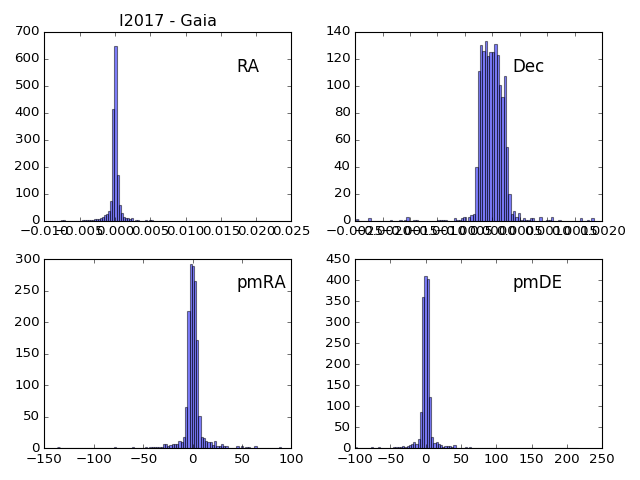

In [360]:
deltara,deltadec,deltapmra,deltapmde = (hra-gra),(hdec-gdec),(hpmra*1000-gpmra),(hpmde*1000-gpmde)
print deltapmra
%matplotlib notebook
plt.subplot(221)
plt.hist(deltara,bins=100,alpha=0.5,label="RA")
plt.title('I2017 - Gaia')
plt.subplot(222)
plt.hist(deltadec,bins=100,alpha=0.5,label="Dec")
plt.subplot(223)
plt.hist(deltapmra[~np.isnan(deltapmra)],bins=100,alpha=0.5)
plt.subplot(224)
plt.hist(deltapmde[~np.isnan(deltapmde)],bins=100,alpha=0.5)
plt.annotate('Dec',fontsize='15', xy=(.8, 0.85), xycoords='figure fraction')
plt.annotate('RA',fontsize='15', xy=(.37, 0.85), xycoords='figure fraction')
plt.annotate('pmRA',fontsize='15', xy=(.37, 0.4), xycoords='figure fraction')
plt.annotate('pmDE',fontsize='15', xy=(.8, 0.4), xycoords='figure fraction')
plt.tight_layout()
plt.show()

In [361]:
pmde_mean,pmde_std=np.mean(deltapmde[~np.isnan(deltapmde)]),np.std(deltapmde[~np.isnan(deltapmde)])
pmra_mean,pmra_std=np.mean(deltara),np.std(deltara)
print np.where(np.abs(deltapmde)>6*pmde_std)[0].shape
print np.where(np.abs(deltapmra)>6*pmra_std)[0].shape
print pmra_std

(5,)
(1577,)
0.00113205800123


In [376]:
toomuch = np.where(np.abs(deltapmde)>6*pmde_std)[0]

## Mollweide Plotting:

In [385]:
# Prefix p for plotting to distinguish these objects from the ones in the table:
import astropy.coordinates as coord
# First make Astropy coordinate objects:
phra = coord.Angle(hra*u.degree)
phra = phra.wrap_at(180*u.degree)
phdec = coord.Angle(hdec*u.degree)

pgra = coord.Angle(gra*u.degree)
pgra = pgra.wrap_at(180*u.degree)
pgdec = coord.Angle(gdec*u.degree)

<IPython.core.display.Javascript object>


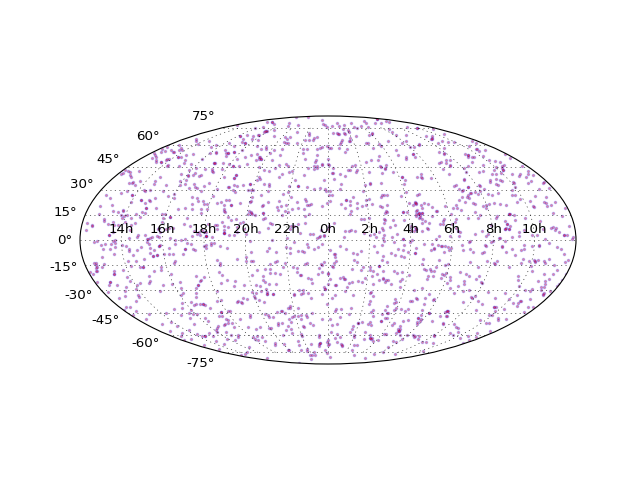

In [395]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(phra.radian, phdec.radian,alpha=0.2,color='blue',s=5)
ax.scatter(pgra.radian, pgdec.radian,alpha=0.2,color='red',s=2)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

In [415]:
print gparallax[np.where(np.isnan(frac_para_error))[0]].shape
print np.where(np.isnan(frac_para_error))
print ''
print 'These do no thave Gaia parallaxes:'
print hip_id[np.where(np.isnan(frac_para_error))[0]]


(42,)
(array([   7,   18,   32,   37,  113,  145,  158,  195,  219,  227,  344,
        480,  489,  491,  570,  617,  639,  656,  688,  689,  716,  728,
        863,  892,  945,  946,  960, 1017, 1084, 1093, 1121, 1183, 1184,
       1185, 1276, 1303, 1350, 1441, 1445, 1456, 1514, 1611]),)

These do no thave Gaia parallaxes:
['HIP443' 'HIP1242' 'HIP2081' 'HIP2762' 'HIP8903' 'HIP11452' 'HIP12351'
 'HIP14576' 'HIP16134' 'HIP16852' 'HIP23875' 'HIP35296' 'GJ273' 'HIP36349'
 'HIP42913' 'HIP46706' 'HIP48659' 'HIP49973' 'HIP51986' 'HIP52190'
 'HIP54182' 'HIP54872' 'HIP65378' 'HIP67301' 'GJ559B' 'GJ559A' 'HIP72622'
 'HIP77516' 'HIP81919' 'HIP82817' 'HIP84123' 'HIP88601' 'GJ702A' 'GJ702B'
 'HIP95501' 'HIP98204' 'HIP101955' 'HIP108752' 'HIP109268' 'HIP109821'
 'HIP113963' 'HIP89937']


So for every object in this sample with a parallax, that parallax is positive and with a small fractional parallax error.  This is good - Bailer-Jones 2015 found that fraction > 20% are much more sensitive to prior selection.  For low f you get an estimator muhc closer to 1/r.  But Bailer-Jones 2015 also found that only 20% of Gaia stars have f<0.2, so its weird that all of our sources are...?  But that is refering to DR1, I don't know about DR2 values of f.

0.0855993462084


<IPython.core.display.Javascript object>


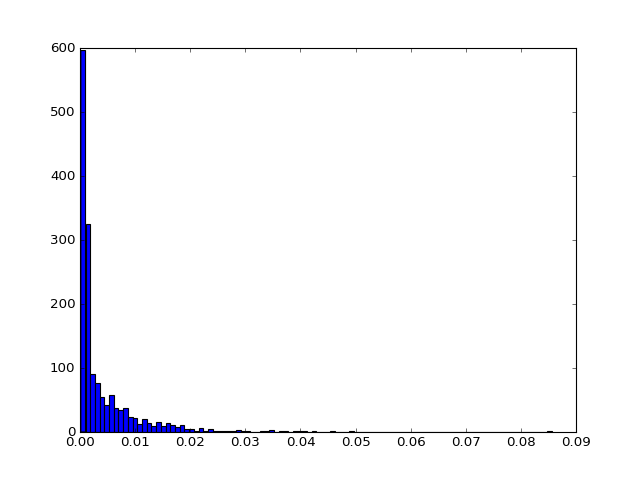

In [417]:
frac_para_error = gparaerror/gparallax

print np.max(frac_para_error[~np.isnan(frac_para_error)])
%matplotlib notebook
plt.hist(frac_para_error[~np.isnan(frac_para_error)],bins=100)
plt.show()

In [427]:
# Root finding numpy:
# Demonstrate concept using the first object on the target list:
L = 1350 #pc
coeff = np.array([(1/L),(-2),((gparallax[0]/1000)/((gparaerror[0]/1000)**2)),-(1/((gparaerror[0]/1000)**2))])
print np.roots(coeff)
print 1/(gparallax[0]/1000)
print hdist[0]

[  1.23176276e+05   3.98205707e+01]
39.8077016091
45.6


<IPython.core.display.Javascript object>


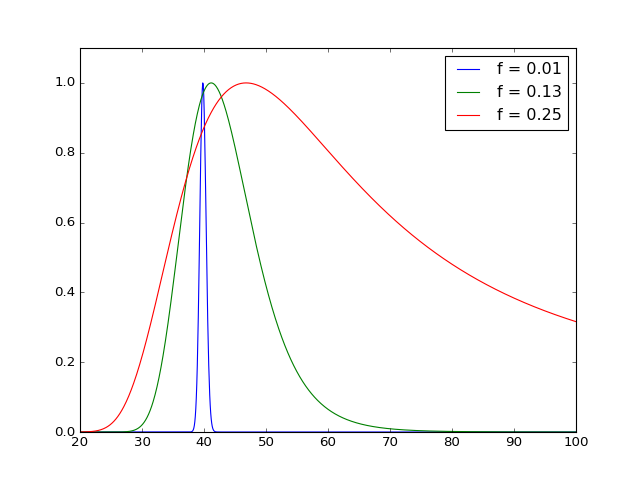

In [462]:
# Proof of concept: posterior distribution
omega,sigma = gparallax[0]/1000,gparaerror[0]/1000
r = np.linspace(20,100,1e3-1)
post = (r**2*np.exp(-r/L)/sigma)*np.exp((-1/(2*(sigma)**2))*(omega-(1/r))**2)
post2 = (r**2*np.exp(-r/L)/(sigma*10))*np.exp((-1/(2*(sigma*10)**2))*(omega-(1/r))**2)
post3 = (r**2*np.exp(-r/L)/(sigma*20))*np.exp((-1/(2*(sigma*20)**2))*(omega-(1/r))**2)

%matplotlib notebook
plt.plot(r,post/np.max(post),label='f = {0}'.format(np.round(sigma/omega,decimals=2)))
plt.plot(r,post2/np.max(post2),label='f = {0}'.format(np.round(sigma*10/omega,decimals=2)))
plt.plot(r,post3/np.max(post3),label='f = {0}'.format(np.round(sigma*20/omega,decimals=2)))
plt.ylim(0,1.1)
plt.legend()